In [1]:
import pandas as pd
import numpy as np
import glob
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt, mpld3
import os
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction import DictVectorizer as DV

from sklearn.cross_validation import cross_val_score
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from copy import deepcopy
from sklearn.cross_validation import train_test_split
import plotly.plotly as py
import plotly.tools as tls

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


You will need to install bayes_opt library 

sudo pip3 install git+https://github.com/fmfn/BayesianOptimization.git

# Load files 

In [2]:
df = pd.read_csv("Data/train_set.csv")

## Filling Nan with zeros. 
There is a one data point that is equal to 0 in plan_code ( which is a feature with categorical datatype AKA object)
So, replace 0 with "zero". 

In [3]:
df=df.fillna(0)
df['plan_code'] = df['plan_code'].replace(0, 'zero')

### Select all object( categorical ) features

In [4]:
objects = df.select_dtypes(include=["object"]).columns

In [5]:
objects

/usr/local/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning:

DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.

/usr/local/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning:

PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.



Index(['country', 'industry', 'industry_category', 'campaign_group',
       'campaign_string', 'plan_code'],
      dtype='object')

### Sweet, now use labelEncoder to deal with categorical data

In [6]:
def encoder(df,listOfObjects):
    encode = LabelEncoder()
    for x in listOfObjects:
        print(x)
        df[x] = encode.fit_transform(df[x])

In [7]:
encoder(df,objects)

country
industry
industry_category
campaign_group
campaign_string
plan_code


### Now data is encoded and ready to go 

In [9]:
# make a copy ( just in case you want your original df to be intact)
train = df.copy()

### make the labels ( y ) and train ( X ), delete "renewed" and "cancellation_request" from train.

In [10]:
labels = train.renewed.values
train.drop(['renewed'], axis=1, inplace=True)
train.drop(['cancellation_request'], axis=1, inplace=True)

# ---> now we want to change and add more stuff to ( train ) only:

## =======================

# Feature Engineering

## =======================


#### If you feel like normalizing the data:

In [20]:
train = train.apply(lambda x:( (x - np.mean(x)) / (np.max(x) - np.min(x)) ))



/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning:

numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning:

numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning:

numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning:

numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning:

numpy boolean subtract, the `-` operato

## --- This is an experiment I am doing, skip it and jump to part 2, or if you want to do more feature engineering, do it above begin{K nearest} , or below end{K nearest}

# begin{K nearest} 

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
#df.groupby("renewed").hist()

In [12]:
knn = KNeighborsClassifier(n_neighbors=3) 

In [13]:
train_knn = df.copy()
y = train_knn.renewed.values
train_knn.drop(['renewed'], axis=1, inplace=True)
X = train_knn

In [14]:

knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [15]:
knn.score(X, y)

0.86757546251217132

In [79]:
v,index=knn.kneighbors(X[1])
index[0]

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



array([   1,  136, 1036])

In [103]:
kfeature = df.copy()
y=kfeature.renewed.values
kfeature.drop(['renewed'], axis=1, inplace=True)

X=kfeature.values

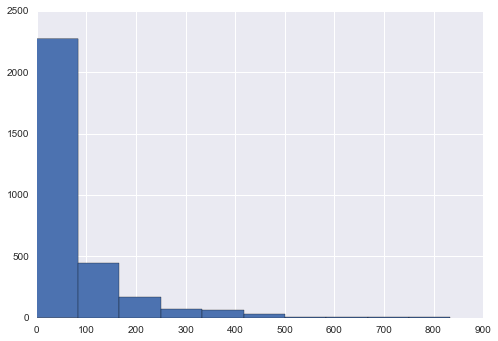

In [50]:
kfeature.days_since_client_created.hist()

In [32]:
# I put this bug on purpose:
i - "hi"

kfeature = df.copy()
kfeature = kfeature.fillna(0)


kfeature.drop(['renewed'], axis=1, inplace=True)
y = kfeature.industry_category.values
kfeature.drop(['industry_category'], axis=1, inplace=True)
kfeature.drop(['cancellation_request'], axis=1, inplace=True)
knn = KNeighborsClassifier(n_neighbors=3) 
X = kfeature.values
knn.fit(X,y)

features_list = ['days_since_signup','days_since_job_created','days_since_invoice_created','days_since_quote_created']

for i in X:
    for j in features_list:
        value = 1 
        val,index=knn.kneighbors(i)
        for m in range(1,len(index[0])-1):
            temp = kfeature.loc[kfeature['id']==index[0][m]]
            value += temp[j].mean()
        kfeature.loc[kfeature['id']==index[0][0],"k_"+j] = value/3
        kfeature.loc[kfeature['id']==index[0][1],"k_"+j] = value/3






TypeError: unsupported operand type(s) for -: 'int' and 'str'

In [16]:
#kfeature.count()

In [19]:
#kfeature = kfeature.fillna(0)


# end{K nearest}

# continue feature engineering

# poly features
### I did not work well and resulted in a lower score, so skip it



In [ ]:
poly_d = df.copy()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

include = ["days_since_signup","days_since_job_created","days_since_invoice_created"]

poly = PolynomialFeatures(degree = 2, include_bias=False)
poly_arr = poly.fit_transform(poly_d[include].values)

print( "New data dimensions: ", poly_arr.shape)

poly_df = pd.DataFrame(poly_arr)
full = poly_df.join(poly_d)


In [ ]:
train = full
train.drop('renewed', axis=1, inplace=True)
train = train.values
labels = poly_d["renewed"].values

# End poly features


# Part 2

# =============

# training Algo = XGboost

# =============

In [21]:
def xgboostcv(max_depth,
              learning_rate,
              n_estimators,
              gamma,
              min_child_weight,
              max_delta_step,
              subsample,
              colsample_bytree,
              silent =True,
              nthread = -1,
              seed = 1234):
    return cross_val_score(XGBClassifier(max_depth = int(max_depth),
                                         learning_rate = learning_rate,
                                         n_estimators = int(n_estimators),
                                         silent = silent,
                                         nthread = nthread,
                                         gamma = gamma,
                                         min_child_weight = min_child_weight,
                                         max_delta_step = max_delta_step,
                                         subsample = subsample,
                                         colsample_bytree = colsample_bytree,
                                         seed = seed,
                                         objective = "binary:logistic"),
                           train,
                           labels,
                           "f1",
                           cv=5).mean()


In [23]:
xgboostBO = BayesianOptimization(xgboostcv,
                                     {'max_depth': (3, 30),
                                      'learning_rate': (0.01, 0.5),
                                      'n_estimators': (90, 800),
                                      'gamma': (100., 0.1),
                                      'min_child_weight': (1, 10),
                                      'max_delta_step': (0, 3),
                                      'subsample': (0.7, 0.8),
                                      'colsample_bytree' :(0.4, 0.99)
                                     })

In [22]:
xgboostBO.maximize()
print('-'*53)

print('Final Results')
print('XGBOOST: %f' % xgboostBO.res['max']['max_val'])

NameError: name 'xgboostBO' is not defined

In [ ]:

params = xgboostBO.res["max"]["max_params"]

print ("F1 Score: ",params)

In [24]:
cross_val_score(XGBClassifier(max_depth = int(19.523816650751428),
                                         learning_rate = 0.08085307502725142,
                                         n_estimators = int( 562.42129696134589),
                                         gamma = 20.01,
                                         min_child_weight = 9.717152178478706,
                                         max_delta_step = 2.8239768010888353,
                                         subsample = 0.70582509792078929,
                                         colsample_bytree = 0.91259070988965141,
                                         objective = "binary:logistic"),
                           train,
                           labels,
                           "f1",
                           cv=5).mean()



0.81670598399468353

In [26]:
def score(model, Xtrain,y,random_state = 0):
    kf = StratifiedKFold(y, n_folds=4, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0]))
    Ave = []
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        model.fit(Xtr, ytr)
        Ave.append(model.score(Xte,yte))
        print (Ave[-1])
        
    print("Average: ",sum(Ave) / float(len(Ave)))
        
        

In [29]:
model = XGBClassifier(max_depth = int(19.523816650751428),
                                         learning_rate = 0.08085307502725142,
                                         n_estimators = int( 562.42129696134589),
                                         gamma = 20.01,
                                         min_child_weight = 9.717152178478706,
                                         max_delta_step = 2.8239768010888353,
                                         subsample = 0.70582509792078929,
                                         colsample_bytree = 0.91259070988965141,
                                         objective = "binary:logistic")
score(model,train.values,labels)

0.869001297017
0.892207792208
0.88961038961
0.885714285714
Average:  0.884133441137


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.89465153970826583

In [ ]:
.892893803147
0.89862124898621254

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(, pred, pos_label=2)

In [ ]:
cross_val_score(model, train, labels, scoring='log_loss')